In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt,save_opt
import matplotlib.pyplot as plt
import torch 
import seaborn as sns
import numpy as np
from infopath.opto import opto_effect, light_generator, light_area
from tqdm import tqdm
import pandas as pd
import os
import json
from infopath.utils.functions import load_data
from infopath.utils.functions import return_trial_type
from infopath.utils.plot_utils import lick_prop_paper_like, lick_prop_with_ci, plot_with_size, strip_right_top_axis
from scipy.stats import ttest_ind
import ast


%reload_ext autoreload
%autoreload 2

font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42

In [2]:
os.chdir("..")

In [3]:
def give_label(row):
    if row.with_tm == 0:
        return 4
    if row.with_ei and not row.with_inh_across:
        return 2
    if not row.with_ei and row.with_inh_across:
        return 3
    if not row.with_ei and not row.with_inh_across:
        if not row.with_spikes:
            return 6
        return -1
    if not row.with_spikes:
        return 5
    if row.l1 == 0.02:
        return 0
    return 1

def model_version(log, commit="", step_size=400):
    model_info = pd.read_table(f"log_dir/{commit}/{log}/model_info.txt", delimiter="      ", engine='python')
    model_info.columns = ["step", "name"]
    df = model_info.groupby("name").max()
    df = df.reset_index()
    df.insert(2, "step_id", (df.step.values / 396).astype("int"))
    results = json.load(open(f"log_dir/{commit}/{log}/results.json", "r"))
    last_step = (len(results["trial_type_accuracy"])-1) * 400
    max_trial_acc = np.max(results["trial_type_accuracy"])
    step_trial_type_and_t_trial = df[df.name.str.contains("best_trial_type_t_trial_ratio")].step.values
    if len(step_trial_type_and_t_trial) == 0:
        model_v = "best_trial_type"
        step = df[df.name=="best_trial_type_model.ckpt"].step.values[0]
        return model_v, step, last_step
    
    actual_acc = results["trial_type_accuracy"][step_trial_type_and_t_trial[0]//400]
    if actual_acc == max_trial_acc:
        model_v = "best_trial_type_t_trial_ratio"
        step = step_trial_type_and_t_trial[0]
    else:
        model_v = "best_trial_type"
        step = df[df.name=="best_trial_type_model.ckpt"].step.values[0]
    return model_v, step, last_step

def opto_figure(ax, dfs, area, color, label=""):
    star_table = np.zeros((3))
    hit_rate_lines = []
    fa_rate_lines = []
    for j in (dfs.session.unique()[0:9]):
        df = dfs[dfs.session == j]
        hit, fa = lick_prop_paper_like(df, area, remove_control=False)
        hit_rate_lines.append(hit)
        fa_rate_lines.append(fa)
    hit_rate_lines = np.array(hit_rate_lines)
    fa_rate_lines = np.array(fa_rate_lines) 
    ax.set_ylim([0., 1])
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(["Off", "W", "D", "R"])
    y = np.array(hit_rate_lines)
    ax.plot(np.array(hit_rate_lines).mean(0), color="black", linestyle="-")
    ax.errorbar(np.arange(4), y.mean(0), yerr=y.std(0)/y.shape[0]**0.5, color=f"C{color}", linestyle="-", capsize=10, label=label)
    for i in range(3):
        star = ttest_ind(hit_rate_lines[:, i+1], hit_rate_lines[:, 0]).pvalue
        star_table[i] = star
        if star < 0.05/4:
            ax.text(i+1, 0.7+0.05*color,  "*", color=f"C{color}", fontsize=20)
    # ax.legend(loc=2)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return ax, hit_rate_lines, fa_rate_lines, star_table

std = lambda x, y: (x.var(2, ddof=1)/x.shape[2] + y.var(2, ddof=1)/y.shape[2])**0.5
@torch.no_grad()
def tune_power(model, powers, df_data, time_vector, lick_classifier, train_jaw, trials=200):
    model.opt.batch_size = trials
    time_vector = np.arange(model.T) * model.timestep + opt.start
    tsts = np.zeros((len(powers), len(model.opt.areas)))
    for i, power in enumerate(powers):
        dfs = []
        seeds = np.arange(0,2)
        for seed in tqdm(seeds):    
            torch.manual_seed(seed)
            stims = torch.randint(2, size=(trials,)).to(model.opt.device)
            state = model.steady_state()
            input_spikes = model.input_spikes(stims)
            model.rsnn.sample_mem_noise(model.T, trials)
            mem_noise = model.rsnn.mem_noise.clone()
            model.rsnn.sample_trial_noise(trials)
            torch.manual_seed(seed)
            spikes, _, jaw, _ = model.step_with_dt(input_spikes, state, mem_noise, dt=50) 
            filt_model = model.filter_fun1(spikes)
            del spikes
            torch.cuda.empty_cache()
            df = opto_effect(
                time_vector,
                model.filter_fun1(train_spikes),
                filt_model,
                session_info_train,
                model,
                stims,
                input_spikes,
                state,
                mem_noise,
                filt_data_jaw=model.filter_fun1(train_jaw),
                filt_jaw=model.filter_fun1(jaw),
                lick_detector=lick_classifier,
                response_time=response_time,
                seed=seed,
                verbose=False,
                power=power,
            )     
            dfs.append(df)        
        dfs = pd.concat(dfs, ignore_index=True)
        dfs["session"] = dfs.index.values // 24
        hit_rate_data = dfdata_to_hitrate(df_data)
        hit_rate_model = df_to_hitrate(dfs)
        delta_hit_data = -(hit_rate_data[1:] - hit_rate_data[0])
        delta_hit = -(hit_rate_model[1:] - hit_rate_model[0]) 

        tsts[i] = np.abs((delta_hit.mean(2) - delta_hit_data.mean(2))/std(delta_hit, delta_hit_data)).mean(0)
    power = [powers[i] for i in np.abs(tsts).argmin(axis=0)]
    print(power)
    return power

def df_to_hitrate(df):
    hit_rate = np.zeros((df.period.nunique(), len(model.opt.areas), df.session.nunique()))
    for j, period in enumerate(['off', 'whisker', 'delay', 'response']):
        for i, area in enumerate(model.opt.areas):
            for k, seed in enumerate(df.session.unique()):
                prop = df[(df.area == area) & (df.period == period) & (df.session == seed)].propabilities.values[0]
                hit_rate[j, i, k] = prop[1] / sum(prop[:2])
    return hit_rate

def dfsingle_to_hitrate(df):
    hit_rate = np.zeros((df.period.nunique(), len(model.opt.areas)))
    for j, period in enumerate(['off', 'whisker', 'delay', 'response']):
        for i, area in enumerate(model.opt.areas):
            prop = df[(df.area == area) & (df.period == period)].propabilities.values[0]
            hit_rate[j, i] = prop[1] / sum(prop[:2])
    return hit_rate


def dfdata_to_hitrate(df, areas=["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"]):
    windows = ["Control", "Stim", "Post", "Response"]
    hit_rate = np.zeros((len(windows), len(areas), df.mouse.nunique())) -1
    for j, period in enumerate(windows):
        for i, area in enumerate(areas):
            for k, mouse in enumerate(df.mouse.unique()):
                prop = df[(df.area == area) & (df.win == period) & (df.mouse == mouse)].groupby("mouse").Hit.mean().values
                hit_rate[j, i, k] = prop
    return hit_rate

In [4]:
logs_total = [
    # Full rec. model
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_54_10_l1across200_seed0",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_59_39_l1across200_seed1",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_17_14_59_37_l1across200_seed2",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_17_0_57_l1across200_seed3",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_17_3_20_l1across200_seed4",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_17_3_20_l1across200_seed5",
    # no sparsity
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_14_17_38_22_l1across0_seed0",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_14_19_49_19_l1across0_seed1",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_14_19_49_19_l1across0_seed2",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_16_57_43_l1across0_seed3",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_16_57_43_l1across0_seed4",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_17_0_57_l1across0_seed5",
    # no ei
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_24_14_32_2_l1across0_seed0",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_24_15_44_47_l1across0_seed1",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_24_15_17_51_l1across0_seed2",
    # no ei no across inh
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_12_28_36_l1across0_seed0",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_12_28_36_l1across0_seed1",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_12_28_36_l1across0_seed2",
    # no across inh 
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_8_17_45_l1across0_seed0",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_9_29_47_l1across0_seed1",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_19_9_29_45_l1across0_seed2",
    # no tm 
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_18_19_28_29_l1across0_seed0",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_18_17_39_17_l1across0_seed1",
    "61789467c93582ede80ee37bcf6ac8c1aa30e22a/2024_7_18_17_16_21_l1across0_seed2",
    # Full no spikes 
    "37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_9_23_16_7_26_l1across200_seed0",
    "37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_9_23_16_7_26_l1across200_seed1",
    "37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_9_23_16_11_7_l1across200_seed2",
    "37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_10_22_15_49_3_l1across200_seed3_nospike",
    "37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_10_22_15_49_1_l1across200_seed4_nospike",
    # Sigma RNN
    "37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_10_24_17_3_25_l1across200_seed1",
    "37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_10_24_17_3_25_l1across200_seed2",
    "37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_10_24_17_3_25_l1across200_seed3",
    "37383bc21e52b1a427bf2086b0659664c2fc1ccc/2024_10_23_21_54_28_l1across200_seed4",
]

In [5]:
# load data
opt = load_training_opt("log_dir/"+logs_total[24])
model = load_model_and_optimizer(opt, reload=True, last_best="last")[0]
model.to("cuda")
(
    train_spikes,
    train_jaw,
    session_info_train,
    test_spikes,
    test_jaw,
    session_info_test,
) = load_data(model)
lick_classifier = torch.load(f"datasets/QuickAccess/lick_classifie_seed{model.opt.seed}.pt")
lick_classifier = lick_classifier.to("cuda")# load the data 
response_time = 12

In [6]:
# Panel 4A
log_best = logs_total[1]
log_path = "log_dir/" + log_best

opt = load_training_opt(log_path)
version, step, _ = model_version(log_best, "")
model = load_model_and_optimizer(opt, reload=True, last_best=version)[0]
time_vector = np.arange(model.T) * model.timestep + opt.start
trials = 1000
model.opt.batch_size = trials
torch.manual_seed(1)
with torch.no_grad():
    stims = torch.ones(trials).to(model.opt.device)
    stims[:trials//2] = 0
    state = model.steady_state()
    model.rsnn.sample_mem_noise(model.T, trials)
    mem_noise = model.rsnn.mem_noise.clone()
    spikes, _, jaw, _ = model.step_with_dt(
        model.input_spikes(stims), 
        state, 
        mem_noise, 
        dt=50
    )
    filt_model = model.filter_fun1(spikes)
    del spikes
    filt_jaw = model.filter_fun1(jaw)
    trial_types, model_perc = return_trial_type(
        model, 
        model.filter_fun1(train_spikes), 
        filt_model, 
        model.filter_fun1(train_jaw), 
        filt_jaw, 
        session_info_train, 
        stims, 
        lick_classifier, 
        response_time=response_time,
    )
print(model_perc)

tensor([0.2040, 0.2960, 0.3780, 0.1220])


In [7]:
# Panel 4C
response_time= 12
opt = load_training_opt(log_path)
time_vector = np.arange(model.T) * model.timestep + opt.start
# version, step, _ = model_version(log_best, "61789467c93582ede80ee37bcf6ac8c1aa30e22a")
# model = load_model_and_optimizer(opt, reload=True, last_best=version)[0]
trials = 10
model.opt.batch_size = trials
torch.manual_seed(1)
with torch.no_grad():
    stims = torch.randint(2, size=(trials,)).to(model.opt.device)
    state = model.steady_state()
    model.rsnn.sample_mem_noise(model.T, trials)
    mem_noise = model.rsnn.mem_noise.clone()
    spikes, _, jaw, _ = model.step_with_dt(
        model.input_spikes(stims), 
        state, 
        mem_noise, 
        dt=50
    )
    filt_model = model.filter_fun1(spikes)
    filt_jaw = model.filter_fun1(jaw)
    trial_types, model_perc = return_trial_type(
        model, 
        model.filter_fun1(train_spikes), 
        filt_model, 
        model.filter_fun1(train_jaw), 
        filt_jaw, 
        session_info_train, 
        stims, 
        lick_classifier, 
        response_time=response_time,
    )

model.rsnn.light_neuron = (1-model.rsnn.excitatory_index.long()).bool()
light, envelope = light_generator(time_vector, "whisker")
envelope = model.filter_fun1(envelope[:, None, None])[:, 0, 0]
light = light_area(light, model.opt.batch_size, model, 0)
torch.manual_seed(1)
with torch.no_grad():
    stims = torch.randint(2, size=(trials,)).to(model.opt.device)
    state = model.steady_state()
    model.rsnn.sample_mem_noise(model.T, trials)
    mem_noise = model.rsnn.mem_noise.clone()
    spikes_light, _, jaw_light, _ = model.step_with_dt(
        model.input_spikes(stims), 
        state, 
        mem_noise, 
        light=light * 0.15, 
        dt=50
    )
    filt_model = model.filter_fun1(spikes_light)
    filt_jaw = model.filter_fun1(jaw_light)
    trial_types_light, model_perc_light = return_trial_type(
        model, 
        model.filter_fun1(train_spikes), 
        filt_model, 
        model.filter_fun1(train_jaw), 
        filt_jaw, 
        session_info_train, 
        stims, 
        lick_classifier, 
        response_time=response_time,
    )
filt_jaw = model.filter_fun2(model.filter_fun1(jaw))
lick = lick_classifier(filt_jaw[-response_time:,:,0].T)
filt_jaw_light = model.filter_fun2(model.filter_fun1(jaw_light))
lick_light = lick_classifier(filt_jaw_light[-response_time:,:,0].T)


/tmp/ipykernel_187528/496151250.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])
/tmp/ipykernel_187528/496151250.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


tensor([0.9891], device='cuda:0', grad_fn=<SelectBackward0>) tensor(97.3291, device='cuda:0')


/tmp/ipykernel_187528/496151250.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])
/tmp/ipykernel_187528/496151250.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""])


tensor([0.0069], device='cuda:0', grad_fn=<SelectBackward0>) tensor(2.2471, device='cuda:0')


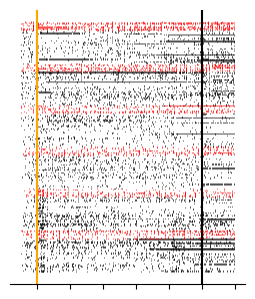

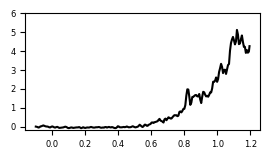

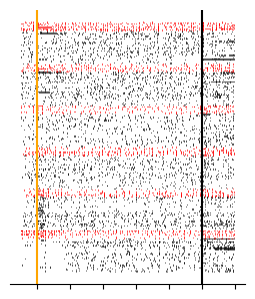

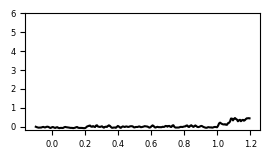

In [8]:
# Panel 4C
reposition = [(0, 200), (1200,1250), (200,400), (1250, 1300), (400, 600), (1300, 1350), (600, 800), (1350, 1400), (800, 1000), (1400, 1450), (1000, 1200), (1450, 1500)]
r = []
for r1 in reposition:
    r.append([i for i in range(r1[0], r1[1])])
r = np.concatenate(r)

trial_to_check = 1
filt_time = model.filter_fun1(torch.tensor(time_vector)[:, None,None])[:,0,0]
color = np.array(["black", "red"])
fig, ax = plot_with_size(60, 70)
tsp, neurid = torch.where(spikes[:,trial_to_check,r].cpu())
tsp = tsp * model.timestep + opt.start
c = ((neurid % 250) > 200).long()
ax.scatter(tsp, neurid, marker="|", s=1, c=color[c], linewidth=0.5)
ax.axvline(0, color="orange")
ax.axvline(1, color="black")
strip_right_top_axis(ax)
ax.spines["left"].set_visible(False)
ax.set_xticklabels([""])
ax.set_yticklabels([""])
ax.set_yticks([])

fig.savefig("FiguresOpto/Figure3/spikes.png", bbox_inches="tight", transparent=True, dpi=500)
print(lick[trial_to_check], filt_jaw[:,trial_to_check].sum())
fig, ax = plot_with_size(60, 30)
ax.plot(filt_time, model.filter_fun1(jaw)[:,trial_to_check].cpu(), color="black")
ax.set_ylim(-0.2,6)
fig.savefig("FiguresOpto/Figure3/jaw.pdf", bbox_inches="tight", transparent=True)

fig, ax = plot_with_size(60, 70)
tsp, neurid = torch.where(spikes_light[:,trial_to_check,r].cpu())
tsp = tsp * model.timestep + opt.start
c = ((neurid % 250) > 200).long()
ax.scatter(tsp, neurid, marker="|", s=1, c=color[c], linewidth=0.5)
ax.axvline(0, color="orange")
ax.axvline(1, color="black")
strip_right_top_axis(ax)
ax.spines["left"].set_visible(False)
ax.set_xticklabels([""])
ax.set_yticklabels([""])
ax.set_yticks([])
fig.savefig("FiguresOpto/Figure3/spikes_light.png", bbox_inches="tight", transparent=True, dpi=500)
print(lick_light[trial_to_check], filt_jaw_light[:,trial_to_check].sum())

fig, ax = plot_with_size(60, 30)
ax.plot(filt_time, model.filter_fun1(jaw_light)[:,trial_to_check].cpu(), color="black")
ax.set_ylim(-0.2,6)
fig.savefig("FiguresOpto/Figure3/jaw_light.pdf", dpi=300, bbox_inches="tight", transparent=True)

In [9]:
std = lambda x, y: (x.var(2, ddof=1)/x.shape[2] + y.var(2, ddof=1)/y.shape[2])**0.5

commit = ""
df = pd.DataFrame(columns=["l1","active_sun_across", "cosine", "abs_dist", "overlap", "tst", "t_trial_pearson_ratio", "with_ei", "with_inh_across", "with_tm", "log", "with_spikes"])
areas = ["wS1", "wS2", "wM1", "wM2", "ALM", "tjM1"]
df_data = pd.read_csv("datasets/opto_data.csv")
num_mice_data = 9
versions = [None for i in logs_total]
k = 0
for version, m in zip(versions, logs_total[:]):
    opt = load_training_opt(f"log_dir/{commit}/{m}")
    if version is None:
        version, step, _ = model_version(m, commit)
    # model = load_model_and_optimizer(opt, reload=True, last_best=version)[0]
    results = json.load(open(f"log_dir/{commit}/{m}/results.json", "r"))
    t_trial_pearson_ratio = results["t_trial_pearson_ratio"][step//400]
    k+=1
    # active_syn_diag = ((model.rsnn._w_rec[:, model.rsnn.off_diag].abs() > 1e-7).sum() / model.rsnn.off_diag.sum()).item()
    dfs = pd.read_csv(f"OptoEffect/Power1_shorter_filt1/opto_effect_{m.split('/')[1]}.csv")
    dfs.propabilities = dfs.propabilities.apply(lambda s: list(ast.literal_eval(s)))
    hit_effect = df_to_hitrate(dfs)
    hit_effect_data = dfdata_to_hitrate(df_data)
    delta_hit_data = -(hit_effect_data[1:] - hit_effect_data[0])
    delta_hit = -(hit_effect[1:] - hit_effect[0]) 
    tst = (delta_hit.mean(2) - delta_hit_data.mean(2))/std(delta_hit, delta_hit_data)
    s = hit_effect_data[0,:].flatten().std()
    sensible = (hit_effect_data[1:].var(2, ddof=1)  < 1)
    overlap = (np.abs(tst)<1.96).sum()
    cos_sim = torch.cosine_similarity(torch.tensor(delta_hit_data.mean(2)).flatten(), torch.tensor(delta_hit.mean(2)).flatten(),dim=0).item()
    abs_dist = (torch.tensor(delta_hit_data.mean(2)).flatten() - torch.tensor(delta_hit.mean(2)).flatten()).abs().mean().item()
    with_spikes = True if opt.spike_function!="sigmoid" else False 
    # print(f"l1 across {opt.l1_decay_across}, active syn across {active_syn_diag:.3f}, cosine similarity: {cos_sim:.3f}, abs dist: {abs_dist:.3f}, overlap: {overlap} / {sensible.sum()}, seed {opt.seed}, tst {np.abs(tst).mean()}")
    # entry = {"l1":opt.l1_decay_across,"active_sun_across":active_syn_diag, "cosine":cos_sim, "abs_dist":abs_dist, "overlap":overlap, "tst":np.abs(tst).mean(), "t_trial_pearson_ratio": t_trial_pearson_ratio, "with_ei":opt.flag_ei, "with_inh_across":opt.restrict_inter_area_inh,"with_tm":opt.loss_trial_wise, "log":m.split("/")[-1], "with_spikes":with_spikes}
    entry = {"l1":opt.l1_decay_across, "cosine":cos_sim, "abs_dist":abs_dist, "overlap":overlap, "tst":np.abs(tst).mean(), "t_trial_pearson_ratio": t_trial_pearson_ratio, "with_ei":opt.flag_ei, "with_inh_across":opt.restrict_inter_area_inh,"with_tm":opt.loss_trial_wise, "log":m.split("/")[-1], "with_spikes":with_spikes}
    df = pd.concat([df, pd.DataFrame(entry, index=[0])], ignore_index=True)

    

In [10]:
df

,l1,active_sun_across,cosine,abs_dist,overlap,tst,t_trial_pearson_ratio,with_ei,with_inh_across,with_tm,log,with_spikes
0,0.02,NaN,0.722261,0.154146,7,3.883133,0.914808,True,True,1,2024_7_17_14_54_10_l1across200_seed0,True
1,0.02,NaN,0.784984,0.139380,6,3.026921,0.927591,True,True,1,2024_7_17_14_59_39_l1across200_seed1,True
2,0.02,NaN,0.385689,0.199843,8,4.130034,0.896552,True,True,1,2024_7_17_14_59_37_l1across200_seed2,True
3,0.02,NaN,0.743969,0.132599,8,2.526392,0.890322,True,True,1,2024_7_19_17_0_57_l1across200_seed3,True
4,0.02,NaN,0.529208,0.172487,8,3.492691,0.861727,True,True,1,2024_7_19_17_3_20_l1across200_seed4,True
5,0.02,NaN,0.577193,0.177996,5,3.840898,0.911901,True,True,1,2024_7_19_17_3_20_l1across200_seed5,True
6,0.00,NaN,0.605122,0.182525,5,3.946681,0.916590,True,True,1,2024_7_14_17_38_22_l1across0_seed0,True
7,0.00,NaN,0.700567,0.168292,5,3.892622,0.942656,True,True,1,2024_7_14_19_49_19_l1across0_seed1,True
8,0.00,NaN,0.719894,0.169453,7,3.378845,0.937403,True,True,1,2024_7_14_19_49_19_l1across0_seed2,True
9,0.00,NaN,0.804934,0.129434,9,2.735907,0.904629,True,True,1,2024_7_19_16_57_43_l1across0_seed3,True


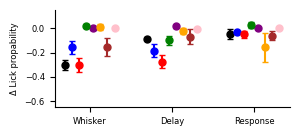

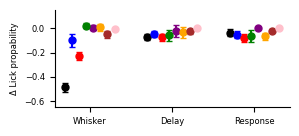

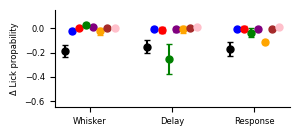

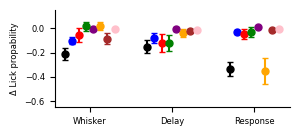

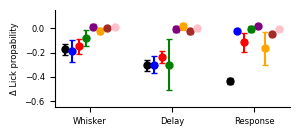

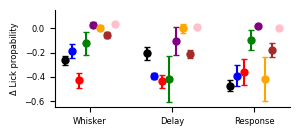

In [11]:
# Panel 3e
# Perturbations in wS1 and tjM1
df_new = df#[df.t_trial_pearson_ratio > 0.88]
df_panel4d = df_new[(df_new.l1 == 0) | (df_new.l1 == 0.02)]
colors = ["blue", "red", "green", "purple", "orange", "brown", "pink"]

xlabels = ["Full", "No sparsity", "Inh across", "No Dale's law", "No TM", "No Spike", "Sigmoid"]
for area_id, area in enumerate(model.opt.areas):
    label = []
    delta_hit_rates = []
    for i, row in enumerate(df_panel4d.iterrows()):
        hit_rate = pd.read_csv(f"OptoEffect/Power1_shorter_filt/opto_effect_{row[1].log}.csv")
        hit_rate.propabilities = hit_rate.propabilities.apply(lambda s: list(ast.literal_eval(s)))
        hit_rate = df_to_hitrate(hit_rate).mean(2)
        delta_hit_rates.append((hit_rate[1:] - hit_rate[0]))
        label.append(give_label(row[1]))
    df_panel4d["label"] = label
    delta_hit_rates = np.stack(delta_hit_rates, axis=2)

    fig, ax = plot_with_size(60, 25)
    strip_right_top_axis(ax)

    points = pd.DataFrame(columns=("area", "delta_hit", "label", "period"))
    max_space = 0.3
    interval_space = (max_space * 2) / len(colors)
    for i in range(3):
        # ax.scatter([i-max_space]*len(colors), -delta_hit_data[i,area_id], label="Data", c="black", alpha=0.3, s=5)
        for k, j in enumerate(df_panel4d["label"].values):
            if (j == -1):
                continue
            # ax.scatter(i+(((j+1)*interval_space) - max_space), delta_hit_rates[i,area_id,k].mean(), c=colors[j], alpha=0.3, s=5)
            entry = {"area":0, "delta_hit":delta_hit_rates[i,area_id,k].mean(), "label":j, "period":i}
            points = pd.concat([points, pd.DataFrame(entry, index=[0])], ignore_index=True)

        ax.errorbar(i-max_space, -delta_hit_data[i,area_id].mean(), yerr=delta_hit_data[i,area_id].std()/np.sqrt(9), fmt='o', c="black", capsize=2, markersize=5)
        for j in points.label.unique():
            ax.errorbar(i+(((j+1)*interval_space) - max_space), points[(points.period == i) & (points.label == j)].delta_hit.mean(), yerr=points[(points.period == i) & (points.label == j)].delta_hit.std()/np.sqrt(points[(points.period == i) & (points.label == j)].shape[0]), fmt='o', c=colors[j], capsize=2, markersize=5)
    ax.set_xticks([0,1,2])
    ax.set_ylim(-0.65, 0.15)
    ax.set_xticklabels(["Whisker", "Delay", "Response"])
    ax.set_ylabel("Δ Lick propability")
    fig.savefig(f"FiguresOpto/Figure3/panel3e_{area}.pdf", bbox_inches='tight', transparent=True)

/tmp/ipykernel_187528/556860597.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(l, mean, yerr=sem, fmt='o', c=colors[l], capsize=3, marker="d", markersize=5)


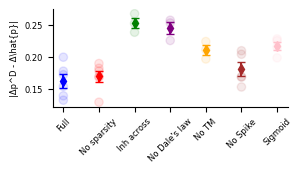

In [12]:
# Panel 3d
# delta hit rate
from infopath.utils.plot_utils import plot_with_size, strip_right_top_axis
colors = ["blue", "red", "green", "purple", "orange", "brown", "pink"]

df_new = df#[df.t_trial_pearson_ratio > 0.88]
df_panel4e = df_new[(df_new.l1 == 0) | (df_new.l1 == 0.02)]


fig, ax = plot_with_size(60, 25)
strip_right_top_axis(ax)
xlabels = ["Full", "No sparsity", "Inh across", "No Dale's law", "No TM", "No Spike", "Sigmoid"]
label = []
for i, row in enumerate(df_panel4e.iterrows()):
    l = give_label(row[1])
    label.append(l)

df_panel4e["label"] = label
df_panel4e = df_panel4e[df_panel4e.label != -1]
ax.scatter(df_panel4e.label, df_panel4e.abs_dist, c=np.array(colors)[df_panel4e.label], alpha=0.1)
# mean = df_panel4e.groupby("label").abs_dist.mean()
# sem = df_panel4e.groupby("label").abs_dist.std() / np.sqrt(df_panel4e.groupby("label").abs_dist.count())
for l in df_panel4e.label.unique():
    mean = df_panel4e[df_panel4e.label == l].abs_dist.mean()
    sem = df_panel4e[df_panel4e.label == l].abs_dist.std() / np.sqrt((df_panel4e.label == l).sum())
    ax.errorbar(l, mean, yerr=sem, fmt='o', c=colors[l], capsize=3, marker="d", markersize=5)
ax.set_xticks(range(len(colors)))
ax.set_xticklabels(xlabels)
# rotate labels by 45 degrees
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_ylabel("|Δp^D - Δ\hat{p}|")
fig.savefig("FiguresOpto/Figure3/panel3d.pdf", bbox_inches='tight', transparent=True)